In [ ]:
import pandas as pd
from ragas import evaluate
from datasets import Dataset

import openai
import os
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision
)

from langchain_openai import ChatOpenAI, OpenAIEmbeddings

In [ ]:
# загрузка данных (вставить нужный датасет)
df_haiku = pd.read_json('answers_rag_sonnet_4_5.jsonl', lines=True)
df_haiku['contexts'] = df_haiku['contexts'].apply(
    lambda x: eval(x) if isinstance(x, str) else x
)
eval_dataset = Dataset.from_pandas(df_haiku)

print("Данные загружены")
print(f"Количество строк: {len(eval_dataset)}")



# OPEN AI токен
os.environ["OPENAI_API_KEY"] = 'Your token'


print("OpenAI настроен")


# LLM через LangChain wrapper
llm = LangchainLLMWrapper(
    ChatOpenAI(
        model="gpt-4o",
        temperature=0
    )
)

# Embeddings через LangChain wrapper
embeddings = LangchainEmbeddingsWrapper(
    OpenAIEmbeddings(
        model="text-embedding-3-small"
    )
)

print("LLM и Embeddings настроены")


# настройка нужных метрик
metrics = [
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision
]

print("Метрики выбраны")



# запуск оценки
print("\nНачинаем оценку...")

try:
    result = evaluate(
        dataset=eval_dataset,
        metrics=metrics,
        llm=llm,
        embeddings=embeddings
    )
    
    print("\nОценка завершена успешно!")
    print("\n" + "="*60)
    print("РЕЗУЛЬТАТЫ:")
    print("="*60)
    print(result)
    
    # сохранение результатов
    df_result = result.to_pandas()

    # вставить нужные названия для файлов
    df_result.to_csv('ragas_evaluation_results_sonnet.csv', index=False)
    print("\nРезультаты сохранены в 'ragas_evaluation_results_sonnet.csv'")
    
    
except Exception as e:
    print(f"\nОшибка при оценке: {e}")


print("\nГотово!")

Данные загружены
Количество строк: 100
OpenAI настроен
LLM и Embeddings настроены
Метрики выбраны

Начинаем оценку...


/var/folders/w3/r9brf2_d2kv2wm_v2lcb5l540000gn/T/ipykernel_68016/547023486.py:38: DeprecationWarning: LangchainLLMWrapper is deprecated and will be removed in a future version. Use llm_factory instead: from openai import OpenAI; from ragas.llms import llm_factory; llm = llm_factory('gpt-4o-mini', client=OpenAI(api_key='...'))
  llm = LangchainLLMWrapper(
/var/folders/w3/r9brf2_d2kv2wm_v2lcb5l540000gn/T/ipykernel_68016/547023486.py:46: DeprecationWarning: LangchainEmbeddingsWrapper is deprecated and will be removed in a future version. Use the modern embedding providers instead: embedding_factory('openai', model='text-embedding-3-small', client=openai_client) or from ragas.embeddings import OpenAIEmbeddings, GoogleEmbeddings, HuggingFaceEmbeddings
  embeddings = LangchainEmbeddingsWrapper(
Evaluating:   2%|▏         | 7/400 [01:09<1:00:10,  9.19s/it]LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Procee


Оценка завершена успешно!

РЕЗУЛЬТАТЫ:
{'faithfulness': 0.6539, 'answer_relevancy': 0.7392, 'context_recall': 0.2402, 'context_precision': 0.1240}

Результаты сохранены в 'ragas_evaluation_results_sonnet.csv'

Готово!


## Оценка полученного результата на валидационном датасете от Haiku

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [53]:
haiku_results = pd.read_csv('ragas_evaluation_results_haiku.csv')
print("Не рассчитанные метрики по вопросам")
haiku_results.isna().sum()

Не рассчитанные метрики по вопросам


user_input             0
retrieved_contexts     0
response               0
reference              0
faithfulness           9
answer_relevancy       2
context_recall         3
context_precision     63
dtype: int64

In [ ]:
haiku_results.describe()

,faithfulness,answer_relevancy,context_recall,context_precision
count,91.000000,98.000000,97.000000,37.000000
mean,0.706013,0.755125,0.324006,0.240878
std,0.269825,0.378017,0.420132,0.381173
min,0.000000,0.000000,0.000000,0.000000
25%,0.500000,0.784734,0.000000,0.000000
50%,0.764706,0.941341,0.000000,0.000000
75%,0.976190,0.987292,0.666667,0.450000
max,1.000000,1.000000,1.000000,1.000000


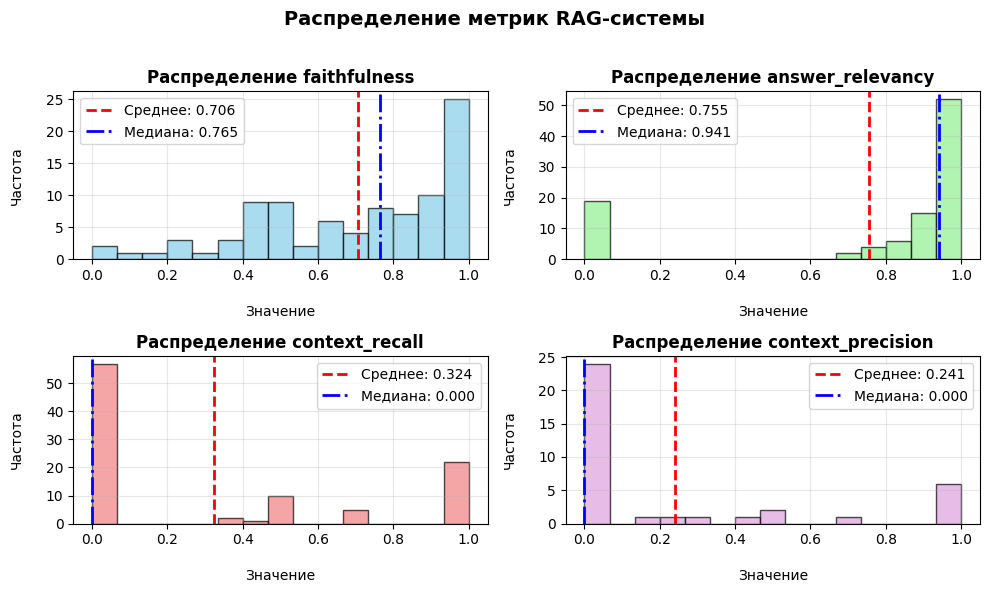

In [ ]:
# распределения метрик 

metrics = ['faithfulness', 'answer_relevancy', 'context_recall', 'context_precision']

fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = axes.flatten()

colors = ['skyblue', 'lightgreen', 'lightcoral', 'plum']

for i, (metric, color) in enumerate(zip(metrics, colors)):
    ax = axes[i]
    data = haiku_results[metric]
    
    # Гистограмма
    ax.hist(data, bins=15, alpha=0.7, color=color, edgecolor='black')
    
    # Вычисляем статистики
    mean_val = data.mean()
    median_val = data.median()
    
    # Линии среднего и медианы
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, 
               label=f'Среднее: {mean_val:.3f}')
    ax.axvline(median_val, color='blue', linestyle='-.', linewidth=2, 
               label=f'Медиана: {median_val:.3f}')
    
    ax.set_title(f'Распределение {metric}', fontsize=12, fontweight='bold')
    ax.set_xlabel('\nЗначение')
    ax.set_ylabel('Частота\n')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Распределение метрик RAG-системы\n', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [54]:
# добавим контекста по типам вопросов 
ground_truth_answers = pd.read_csv('tourism_travel_questions_with_ground_truth_ver_short.csv')[['question', 'difficulty_level', 'question_type','topic']]

ground_truth_answers
haiku_results_with_topics = haiku_results.merge(ground_truth_answers, 
                                                    left_on='user_input',
                                                    right_on='question',
                                                    validate='1:1')\
                                            .drop(columns=['question'])\
                                            .copy()

haiku_results_with_topics.head(3)

,user_input,retrieved_contexts,response,reference,faithfulness,answer_relevancy,context_recall,context_precision,difficulty_level,question_type,topic
0,What documents do I need to travel internation...,"[""customs. Also, do get a Travel insurance whi...","Based on the provided context, here are the do...","For international travel, you typically need a...",1.000000,0.963974,0.5,NaN,easy,factual,safety
1,What is the Eiffel Tower's location?,"['Of course, you can also take the funicular. ...",The context provided does not specify the loca...,"The Eiffel Tower is located in Paris, France. ...",0.500000,0.000000,0.0,NaN,easy,factual,attractions
2,What are the typical business hours in Spain?,"['customary schedule for work, dining and stor...","In Spain, the typical business hours for most ...",Business hours in Spain typically follow the p...,0.882353,0.935404,0.5,NaN,easy,factual,culture


In [58]:
# Статистика по уровням сложности
print("=" * 60)
print("СТАТИСТИКА ПО УРОВНЯМ СЛОЖНОСТИ (difficulty_level):")
print("=" * 60)
for metric in metrics:
    print(f"\nМетрика: {metric}")
    stats = haiku_results_with_topics.groupby('difficulty_level')[metric].agg([
        'count', 'mean', 'std', 'min', 'median', 'max'
    ]).round(3)
    print(stats)
    print("-" * 40)

# Статистика по типам вопросов
print("\n" + "=" * 60)
print("СТАТИСТИКА ПО ТИПАМ ВОПРОСОВ (question_type):")
print("=" * 60)
for metric in metrics:
    print(f"\nМетрика: {metric}")
    stats = haiku_results_with_topics.groupby('question_type')[metric].agg([
        'count', 'mean', 'std', 'min', 'median', 'max'
    ]).round(3)
    print(stats)
    print("-" * 40)

# Статистика по темам
print("\n" + "=" * 60)
print("СТАТИСТИКА ПО ТЕМАМ (topic):")
print("=" * 60)
for metric in metrics:
    print(f"\nМетрика: {metric}")
    stats = haiku_results_with_topics.groupby('topic')[metric].agg([
        'count', 'mean', 'std', 'min', 'median', 'max'
    ]).round(3)
    print(stats)
    print("-" * 40)

СТАТИСТИКА ПО УРОВНЯМ СЛОЖНОСТИ (difficulty_level):

Метрика: faithfulness
                  count   mean    std    min  median  max
difficulty_level                                         
easy                 26  0.740  0.267  0.000   0.829  1.0
hard                 22  0.680  0.241  0.250   0.703  1.0
medium               26  0.762  0.255  0.062   0.828  1.0
off-topic            17  0.601  0.316  0.091   0.500  1.0
----------------------------------------

Метрика: answer_relevancy
                  count   mean    std    min  median    max
difficulty_level                                           
easy                 28  0.870  0.258  0.000   0.964  1.000
hard                 25  0.759  0.345  0.000   0.903  0.997
medium               28  0.970  0.040  0.841   0.985  1.000
off-topic            17  0.207  0.388  0.000   0.000  0.988
----------------------------------------

Метрика: context_recall
                  count   mean    std  min  median  max
difficulty_level           

### Если убрать оффтопик вопросы 

In [62]:
haiku_results_no_offtopic = haiku_results_with_topics.query('difficulty_level != "off-topic"').reset_index(drop=True)
print('Количество запросов не off-topic:', haiku_results_no_offtopic.shape[0])

Количество запросов не off-topic: 83


In [63]:
haiku_results_no_offtopic.describe()

,faithfulness,answer_relevancy,context_recall,context_precision
count,74.000000,81.000000,80.000000,30.000000
mean,0.730132,0.870221,0.367857,0.297083
std,0.254315,0.256656,0.425495,0.403845
min,0.000000,0.000000,0.000000,0.000000
25%,0.533422,0.885604,0.000000,0.000000
50%,0.777778,0.962205,0.000000,0.000000
75%,0.949580,0.989812,0.750000,0.500000
max,1.000000,1.000000,1.000000,1.000000


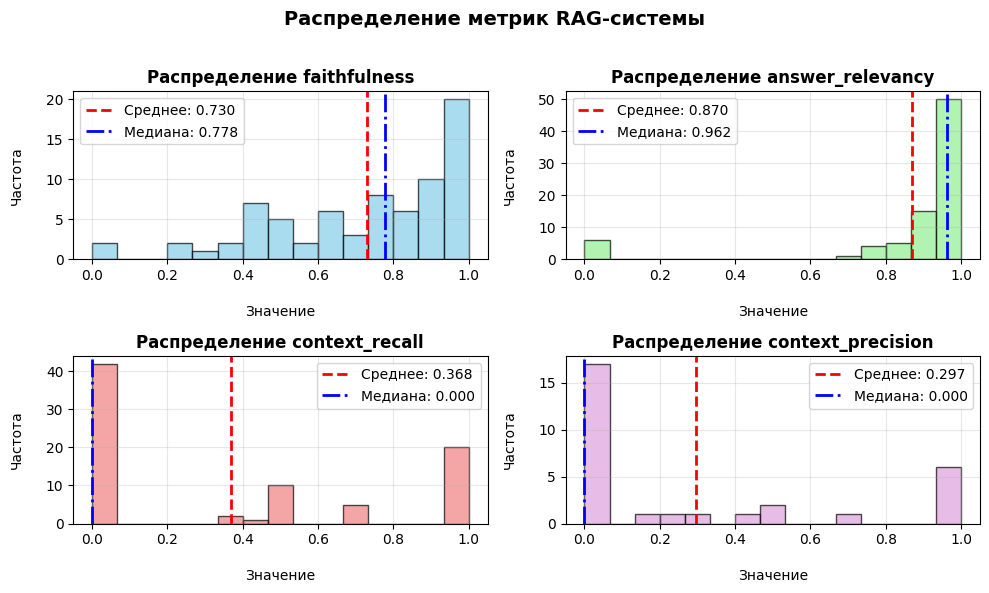

In [ ]:
# распределения метрик 

metrics = ['faithfulness', 'answer_relevancy', 'context_recall', 'context_precision']

fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = axes.flatten()

colors = ['skyblue', 'lightgreen', 'lightcoral', 'plum']

for i, (metric, color) in enumerate(zip(metrics, colors)):
    ax = axes[i]
    data = haiku_results_no_offtopic[metric]
    
    # Гистограмма
    ax.hist(data, bins=15, alpha=0.7, color=color, edgecolor='black')
    
    # Вычисляем статистики
    mean_val = data.mean()
    median_val = data.median()
    
    # Линии среднего и медианы
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, 
               label=f'Среднее: {mean_val:.3f}')
    ax.axvline(median_val, color='blue', linestyle='-.', linewidth=2, 
               label=f'Медиана: {median_val:.3f}')
    
    ax.set_title(f'Распределение {metric}', fontsize=12, fontweight='bold')
    ax.set_xlabel('\nЗначение')
    ax.set_ylabel('Частота\n')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Общий заголовок
plt.suptitle('Распределение метрик RAG-системы\n', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Оценка полученного результата на валидационном датасете от Sonnet

In [66]:
sonnet_results = pd.read_csv('ragas_evaluation_results_sonnet.csv')
print("Не рассчитанные метрики по вопросам")
sonnet_results.isna().sum()

Не рассчитанные метрики по вопросам


user_input             0
retrieved_contexts     0
response               0
reference              0
faithfulness          10
answer_relevancy       2
context_recall         0
context_precision     59
dtype: int64

In [67]:
sonnet_results.describe()

,faithfulness,answer_relevancy,context_recall,context_precision
count,90.000000,98.000000,100.000000,41.000000
mean,0.653932,0.739180,0.240155,0.123984
std,0.287803,0.392746,0.314666,0.307951
min,0.000000,0.000000,0.000000,0.000000
25%,0.454545,0.776811,0.000000,0.000000
50%,0.654762,0.941341,0.000000,0.000000
75%,0.912500,0.989173,0.446429,0.000000
max,1.000000,1.000000,1.000000,1.000000


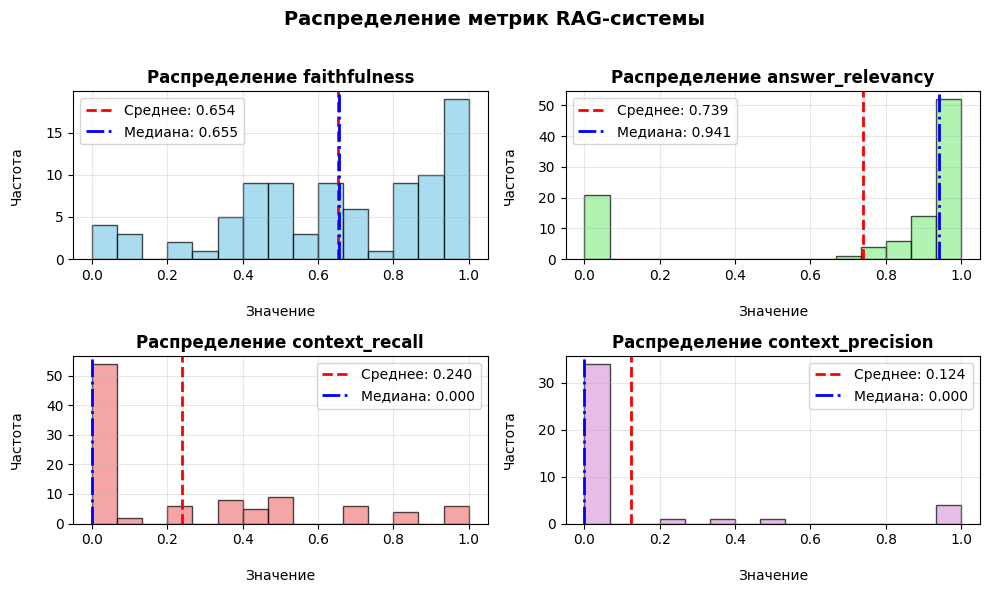

In [ ]:
# распределения метрик 

metrics = ['faithfulness', 'answer_relevancy', 'context_recall', 'context_precision']

fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = axes.flatten()

colors = ['skyblue', 'lightgreen', 'lightcoral', 'plum']

for i, (metric, color) in enumerate(zip(metrics, colors)):
    ax = axes[i]
    data = sonnet_results[metric]
    
    # Гистограмма
    ax.hist(data, bins=15, alpha=0.7, color=color, edgecolor='black')
    
    # Вычисляем статистики
    mean_val = data.mean()
    median_val = data.median()
    
    # Линии среднего и медианы
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, 
               label=f'Среднее: {mean_val:.3f}')
    ax.axvline(median_val, color='blue', linestyle='-.', linewidth=2, 
               label=f'Медиана: {median_val:.3f}')
    
    ax.set_title(f'Распределение {metric}', fontsize=12, fontweight='bold')
    ax.set_xlabel('\nЗначение')
    ax.set_ylabel('Частота\n')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Общий заголовок
plt.suptitle('Распределение метрик RAG-системы\n', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [69]:
# добавим контекста по типам вопросов 
ground_truth_answers = pd.read_csv('tourism_travel_questions_with_ground_truth_ver_long.csv')[['question', 'difficulty_level', 'question_type','topic']]

sonnet_results_with_topics = sonnet_results.merge(ground_truth_answers, 
                                                    left_on='user_input',
                                                    right_on='question',
                                                    validate='1:1')\
                                            .drop(columns=['question'])\
                                            .copy()

sonnet_results_with_topics.head(3)

,user_input,retrieved_contexts,response,reference,faithfulness,answer_relevancy,context_recall,context_precision,difficulty_level,question_type,topic
0,What documents do I need to travel internation...,"[""customs. Also, do get a Travel insurance whi...","Based on the provided context, here are the do...","For international travel, you typically need a...",0.916667,0.963968,0.250000,NaN,easy,factual,safety
1,What is the Eiffel Tower's location?,"['Of course, you can also take the funicular. ...",The context provided does not specify the loca...,"The Eiffel Tower is located in Paris, France, ...",0.500000,0.000000,0.000000,0.0,easy,factual,attractions
2,What are the typical business hours in Spain?,"['customary schedule for work, dining and stor...","In Spain, the typical business hours for most ...","In Spain, typical business hours for shops are...",0.933333,0.935404,0.333333,NaN,easy,factual,culture


In [70]:
# Статистика по уровням сложности
print("=" * 60)
print("СТАТИСТИКА ПО УРОВНЯМ СЛОЖНОСТИ (difficulty_level):")
print("=" * 60)
for metric in metrics:
    print(f"\nМетрика: {metric}")
    stats = sonnet_results_with_topics.groupby('difficulty_level')[metric].agg([
        'count', 'mean', 'std', 'min', 'median', 'max'
    ]).round(3)
    print(stats)
    print("-" * 40)

# Статистика по типам вопросов
print("\n" + "=" * 60)
print("СТАТИСТИКА ПО ТИПАМ ВОПРОСОВ (question_type):")
print("=" * 60)
for metric in metrics:
    print(f"\nМетрика: {metric}")
    stats = sonnet_results_with_topics.groupby('question_type')[metric].agg([
        'count', 'mean', 'std', 'min', 'median', 'max'
    ]).round(3)
    print(stats)
    print("-" * 40)

# Статистика по темам
print("\n" + "=" * 60)
print("СТАТИСТИКА ПО ТЕМАМ (topic):")
print("=" * 60)
for metric in metrics:
    print(f"\nМетрика: {metric}")
    stats = sonnet_results_with_topics.groupby('topic')[metric].agg([
        'count', 'mean', 'std', 'min', 'median', 'max'
    ]).round(3)
    print(stats)
    print("-" * 40)

СТАТИСТИКА ПО УРОВНЯМ СЛОЖНОСТИ (difficulty_level):

Метрика: faithfulness
                  count   mean    std    min  median  max
difficulty_level                                         
easy                 25  0.695  0.279  0.062   0.667  1.0
hard                 25  0.599  0.256  0.000   0.632  1.0
medium               23  0.734  0.264  0.000   0.800  1.0
off-topic            17  0.567  0.355  0.000   0.500  1.0
----------------------------------------

Метрика: answer_relevancy
                  count   mean    std    min  median    max
difficulty_level                                           
easy                 28  0.808  0.341  0.000   0.956  1.000
hard                 27  0.778  0.337  0.000   0.927  1.000
medium               26  0.973  0.041  0.841   0.987  1.000
off-topic            17  0.207  0.388  0.000   0.000  0.988
----------------------------------------

Метрика: context_recall
                  count   mean    std  min  median  max
difficulty_level           

### Если убрать оффтопик вопросы 

In [71]:
sonnet_results_no_offtopic = sonnet_results_with_topics.query('difficulty_level != "off-topic"').reset_index(drop=True)
print('Количество запросов не off-topic:', sonnet_results_no_offtopic.shape[0])

Количество запросов не off-topic: 83


In [72]:
sonnet_results_no_offtopic.describe()

,faithfulness,answer_relevancy,context_recall,context_precision
count,73.000000,81.000000,83.000000,32.000000
mean,0.674244,0.850890,0.265247,0.158854
std,0.268780,0.289931,0.307039,0.341538
min,0.000000,0.000000,0.000000,0.000000
25%,0.473684,0.885589,0.000000,0.000000
50%,0.666667,0.962225,0.200000,0.000000
75%,0.900000,0.990583,0.500000,0.000000
max,1.000000,1.000000,1.000000,1.000000


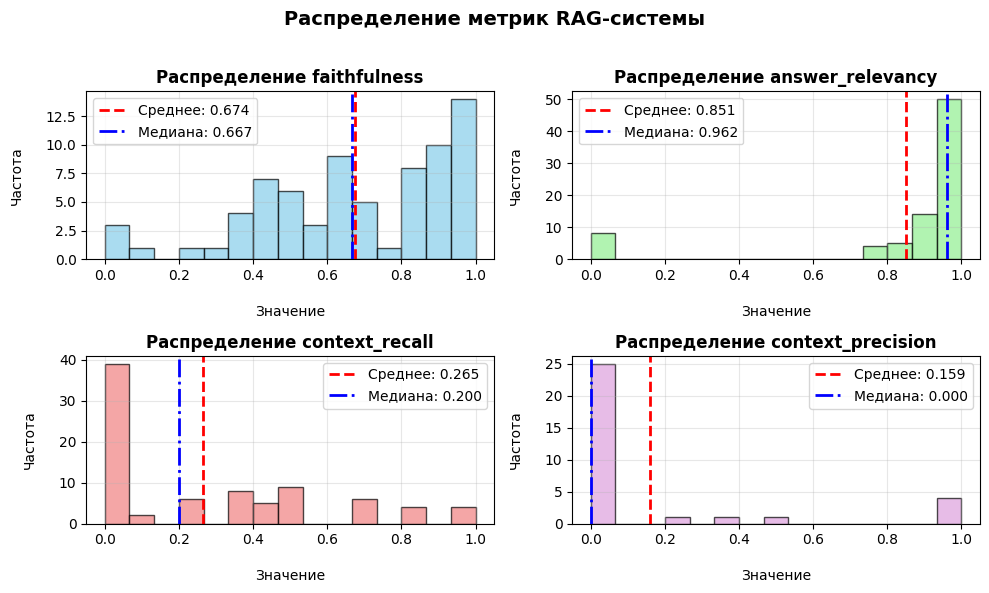

In [ ]:
# распределения метрик 

metrics = ['faithfulness', 'answer_relevancy', 'context_recall', 'context_precision']

fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = axes.flatten()

colors = ['skyblue', 'lightgreen', 'lightcoral', 'plum']

for i, (metric, color) in enumerate(zip(metrics, colors)):
    ax = axes[i]
    data = sonnet_results_no_offtopic[metric]
    
    # Гистограмма
    ax.hist(data, bins=15, alpha=0.7, color=color, edgecolor='black')
    
    # Вычисляем статистики
    mean_val = data.mean()
    median_val = data.median()
    
    # Линии среднего и медианы
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, 
               label=f'Среднее: {mean_val:.3f}')
    ax.axvline(median_val, color='blue', linestyle='-.', linewidth=2, 
               label=f'Медиана: {median_val:.3f}')
    
    ax.set_title(f'Распределение {metric}', fontsize=12, fontweight='bold')
    ax.set_xlabel('\nЗначение')
    ax.set_ylabel('Частота\n')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Общий заголовок
plt.suptitle('Распределение метрик RAG-системы\n', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()